In [1]:
import re, os
import string
import joblib
import numpy as np
import pandas as pd
from glob import glob
from gensim.models import FastText
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
sinhalese_chars = [
                "අ", "ආ", "ඇ", "ඈ", "ඉ", "ඊ",
                "උ", "ඌ", "ඍ", "ඎ", "ඏ", "ඐ",
                "එ", "ඒ", "ඓ", "ඔ", "ඕ", "ඖ",
                "ං", "ඃ",
                "ක", "ඛ", "ග", "ඝ", "ඞ", "ඟ",
                "ච", "ඡ", "ජ", "ඣ", "ඤ", "ඥ", "ඦ",
                "ට", "ඨ", "ඩ", "ඪ", "ණ", "ඬ",
                "ත", "ථ", "ද", "ධ", "න", "ඳ",
                "ප", "ඵ", "බ", "භ", "ම", "ඹ",
                "ය", "ර", "ල", "ව",
                "ශ", "ෂ", "ස", "හ", "ළ", "ෆ",
                "෴", "\u200d"
            ]
# "\u200d" is used with "යංශය" - කාව්‍ය, "රේඵය" - වර්‍තමාන, "Both" - මහාචාර්‍ය්‍ය, "රකාරාංශය" - මුද්‍රණය

simplify_characters_dict = {
                        # Consonant
                        "ඛ": "ක",
                        "ඝ": "ග",
                        "ඟ": "ග",
                        "ඡ": "ච",
                        "ඣ": "ජ",
                        "ඦ": "ජ",
                        "ඤ": "ඥ",
                        "ඨ": "ට",
                        "ඪ": "ඩ",
                        "ණ": "න",
                        "ඳ": "ද",
                        "ඵ": "ප",
                        "භ": "බ",
                        "ඹ": "බ",
                        "ශ": "ෂ",
                        "ළ": "ල",

                        # Vowels
                        "ආ": "අ",
                        "ඈ": "ඇ",
                        "ඊ": "ඉ",
                        "ඌ": "උ",
                        "ඒ": "එ",
                        "ඕ": "ඔ",

                        "ා": "",
                        "ෑ": "ැ",
                        "ී": "ි",
                        "ූ": "ු",
                        "ේ": "ෙ",
                        "ෝ": "ො",
                        "ෲ": "ෘ"
                    }

partition_dir = 'data/All/*.tsv'
W2Vweights = 'weights/FastText.bin'
stem_path = 'docs/stem_dict.txt'

processed_inputs = 'docs/processed_inputs.txt'
processed_outputs = 'docs/processed_outputs.txt'

svm_weights = 'weights/svm_weights.txt'
rf_weights = 'weights/rf_weights.txt'

In [3]:
def get_simplified_character(character: str) -> str:
    if len(character) != 1:
        raise TypeError("character should be a string with length 1")
    try:
        return simplify_characters_dict[character]
    except KeyError:
        return character

In [4]:
def split_tokens(text: str) -> list:
    """
    tokenize text
    :param text: text
    :return: token list
    """
    return [token for token in
            re.split(r'[.…,‌ ¸‚\"/|—¦”‘\'“’´!@#$%^&*+\-£?˜()\[\]{\}:;–Ê  �‪‬‏0123456789' + ']', text)
            if token != ""]


def simplify_sinhalese_text(text: str) -> str:
    """
    simplify
    :param text:
    :return:
    """
    modified_text = ""
    for c in text:
        modified_text += get_simplified_character(c)
    return modified_text


def stem_word(word: str) -> str:
    """
    Stemming words
    :param word: word
    :return: stemmed word
    """
    if len(word) < 4:
        return word

    # remove 'ට'
    if word[-1] == 'ට':
        return word[:-1]

    # remove 'ද'
    if word[-1] == 'ද':
        return word[:-1]

    # remove 'ටත්'
    if word[-3:] == 'ටත්':
        return word[:-3]

    # remove 'එක්'
    if word[-3:] == 'ෙක්':
        return word[:-3]

    # remove 'එ'
    if word[-1:] == 'ෙ':
        return word[:-1]

    # remove 'ක්'
    if word[-2:] == 'ක්':
        return word[:-2]

    # remove 'ගෙ' (instead of ගේ because this step comes after simplifying text)
    if word[-2:] == 'ගෙ':
        return word[:-2]

    # else
    return word


def tokenize(text: str) -> list:
    # todo: add stem_word(token) and simplify_sinhalese_text methods
    return [stem_word(token) for token in split_tokens(simplify_sinhalese_text(text.strip('"')).lower())]

In [5]:
def make_stem_dict():
    lemma_dict = {}
    with open(stem_path, encoding="utf8") as f:
        for line in f:
            token, lemma = line.split('\t')
            lemma_dict[token.strip()] = lemma.strip()
    return lemma_dict 

def clean_str(text):
    text = ''.join([char for char in list(text) if (char not in string.punctuation)])
    return text.lower().strip()

def word_lemmatization(text, lemma_dict):
    text = text.split(' ')
    text = [token.strip() for token in text]
    text = [lemma_dict[token] if (token in lemma_dict) else token for token in  text]
    text = [token for token in text if len(token) > 0]
    text = ' '.join(text)
    return text

def preprocess_text(text, lemma_dict):
    text = clean_str(text)
    text = word_lemmatization(text, lemma_dict)
    return text

def preprocess_texts(texts):
    lemma_dict = make_stem_dict()
    updated_text = []

    if isinstance(texts, np.ndarray) or isinstance(texts, list):
        updated_tweets = [preprocess_text(text, lemma_dict) for text in texts]
    elif isinstance(texts, np.str_)  or isinstance(texts, str):
        updated_tweets = [preprocess_text(texts, lemma_dict)]

    return np.array(updated_tweets)

In [6]:
def build_dictionary(corpus_token: list) -> dict:
    word_frequency = {}
    dictionary = {}

    for tweet in corpus_token:
        for token in tweet:
            if token in word_frequency:
                word_frequency[token] += 1
            else:
                word_frequency[token] = 1

    frequencies = list(word_frequency.values())
    unique_words = list(word_frequency.keys())

    # sort words by its frequency
    frequency_indexes = np.argsort(frequencies)[::-1]  # reverse for descending
    for index, frequency_index in enumerate(frequency_indexes):
        # 0 is not used and 1 is for UNKNOWN
        dictionary[unique_words[frequency_index]] = index + 2

    return dictionary

In [7]:
def load_data(partition_dir: str) -> pd.DataFrame:
    csv_files = glob(partition_dir)
    data = pd.DataFrame()
    for file in csv_files:
            df_i = pd.read_csv(
                        file, 
                        sep='\t', 
                        header=None, 
                        on_bad_lines='skip'
                        )
            data = pd.concat([data, df_i])

    data[1].fillna('O', inplace=True)

    data[0] = data[0].str.strip()
    data[1] = data[1].str.strip()
    visualize_entity_imbalance(data)
    return data

def visualize_entity_imbalance(data: pd.DataFrame) -> None:
    """
    Visualize the imbalance of entities in the dataset
    :param data: dataframe
    :return: None
    """
    entities = data[1].value_counts()
    entities.plot(kind='bar')
    plt.xlabel('Entities')
    plt.ylabel('Count')
    plt.title('Entity Distribution')
    plt.show()

def create_sentences(data: pd.DataFrame) -> list:
    texts = data[0].values
    labels = data[1].values

    input_sentences = []
    output_sentences = []

    input_sentence = ''
    output_sentence = ''

    for text, label in zip(texts, labels):
        if text.strip() == '.':
            input_sentence = input_sentence.strip()
            output_sentence = output_sentence.strip()
            
            input_sentences.append(input_sentence)
            output_sentences.append(output_sentence)

            input_sentence = ''
            output_sentence = ''

        else:
            input_sentence = input_sentence + ' ' + str(text).strip()
            output_sentence = output_sentence + ' ' + str(label).strip()

    return input_sentences, output_sentences

In [8]:
data = load_data(partition_dir)
input_sentences, output_sentences = create_sentences(data)

In [9]:
input_sentences_preprocessed = preprocess_texts(input_sentences)
input_token_list = [tokenize(input_sentence.strip()) for input_sentence in input_sentences_preprocessed]
output_label_list = [output_sentence.strip().split(' ') for output_sentence in output_sentences]
word2index = build_dictionary(input_token_list)

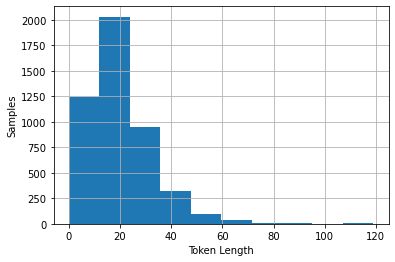

count    4694.000000
mean       19.911376
std        12.463500
min         0.000000
10%         7.000000
20%        10.000000
30%        12.000000
40%        15.000000
50%        17.000000
60%        20.000000
70%        24.000000
80%        28.000000
90%        36.000000
max       119.000000
dtype: float64


In [10]:
def visualize_token_length_distribution(input_token_list: list) -> None:
    """
    Visualize the token length distribution
    :param input_token_list: list of tokenized sentences
    :return: None
    """
    X_len = [len(i) for i in input_token_list]
    X_len = pd.Series(X_len)
    X_len.hist()
    plt.xlabel('Token Length')
    plt.ylabel('Samples')
    plt.show()
    
    print(X_len.describe(percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))



visualize_token_length_distribution(input_token_list)

In [11]:
# Setting Max length 100 is the best for the model to work
max_length = 80
OOV_TOKEN = '<OOV>'

def pad_sentences(
                 input_token_list: list, 
                 output_label_list: list,
                 max_length: int) -> list:
    """
    Pad sentences with OOV token
    :param input_token_list: list of tokenized sentences
    :param max_length: max length of the sentences
    :return: padded sentences
    """
    padded_input_token_list = []
    padded_output_label_list = []
    for input_token, output_label in zip(input_token_list, output_label_list):
        if len(input_token) > max_length:
            input_token = input_token[:max_length]
            output_label = output_label[:max_length]
        else:
            input_token.extend([OOV_TOKEN] * (max_length - len(input_token)))
            output_label.extend(['O'] * (max_length - len(output_label)))
        padded_input_token_list.append(input_token)
        padded_output_label_list.append(output_label)
    return padded_input_token_list, padded_output_label_list

In [12]:
def create_word_embeddings(input_token_list):
    if not os.path.exists(W2Vweights):
        W2V = FastText(input_token_list, min_count=1)
        W2V.save(W2Vweights)
    else:
        W2V = FastText.load(W2Vweights)
    return W2V

In [13]:
W2V = create_word_embeddings(input_token_list)
print("Vocabulary Size : ", len(W2V.wv.key_to_index))
print("Embedding Size : ", W2V.vector_size)

Vocabulary Size :  14516
Embedding Size :  100


# **Formulate Feature Classification**

In [14]:
def create_binary_data(input_token_list, output_label_list):
    input_token_flatten =  []
    output_label_flatten = []
    mismatched_count = 0

    saved_inputs = open(processed_inputs, 'wb')
    saved_outputs = open(processed_outputs, 'wb')

    for idx, (input_token, output_label) in enumerate(zip(input_token_list, output_label_list)):
        if len(input_token) == len(output_label):
            input_token_flatten.extend(input_token)
            output_label_flatten.extend(output_label)

            input_sentence = input_sentences[idx]
            output_sentence = output_sentences[idx]

            saved_inputs.write(input_sentence.encode('utf-8') + b'\n')
            saved_outputs.write(output_sentence.encode('utf-8') + b'\n')
            
        else:
            mismatched_count += 1
    
    saved_inputs.close()
    saved_outputs.close()
    
    print("Mismatched Count : ", mismatched_count)

    input_token_flatten = np.array(input_token_flatten)
    output_label_flatten = np.array(output_label_flatten)

    Y = output_label_flatten != 'O'
    Y = Y.astype(int)
    X = W2V.wv[input_token_flatten]

    return X, Y

In [15]:
def class_imbalance(Y):
    class_weights = compute_class_weight(
                                    'balanced',
                                    classes = np.unique(Y),
                                    y = Y)

    '''

    Eqn : Total Number of Samples / (2 * Number of Samples in Given Class)

    '''
    class_weights = {i : class_weights[i] for i in range(len(set(Y)))}
    return class_weights

In [16]:
Xt1, Yt1 = create_binary_data(input_token_list, output_label_list)

Xt1_train, Xt1_test, Yt1_train, Yt1_test = train_test_split(
                                                            Xt1, 
                                                            Yt1, 
                                                            test_size=0.2, 
                                                            random_state=42
                                                            )
class_weights_t1 = class_imbalance(Yt1_train)

Mismatched Count :  1928


In [17]:

if not os.path.exists(svm_weights):
    svm = SVC(
            kernel='rbf', 
            C=1, 
            decision_function_shape='ovo',
            class_weight=class_weights_t1,
            )
    svm.fit(Xt1_train, Yt1_train)
    joblib.dump(svm, svm_weights)
else:
    svm = joblib.load(svm_weights)

In [18]:
Pt1_train = svm.predict(Xt1_train)
Pt1_test = svm.predict(Xt1_test)

print("Training Accuracy : ", accuracy_score(Yt1_train, Pt1_train))
print("Testing Accuracy : ", accuracy_score(Yt1_test, Pt1_test))

Training Accuracy :  0.9522685107100691
Testing Accuracy :  0.9200584663818304


In [19]:
print(classification_report(Yt1_test, Pt1_test, target_names=['O', '~O']))

              precision    recall  f1-score   support

           O       0.96      0.95      0.95      7691
          ~O       0.69      0.74      0.71      1203

    accuracy                           0.92      8894
   macro avg       0.83      0.84      0.83      8894
weighted avg       0.92      0.92      0.92      8894



# **Formulate Entity Classification**

In [20]:
def create_entity_data(input_token_list, output_label_list):
    input_token_flatten =  []
    output_label_flatten = []
    mismatched_count = 0

    for input_token, output_label in zip(input_token_list, output_label_list):
        if len(input_token) == len(output_label):
            input_token = np.array(input_token)
            output_label = np.array(output_label)

            input_entity_tokens = input_token[output_label != 'O']
            output_entity_labels = output_label[output_label != 'O']

            input_token_flatten.extend(input_entity_tokens)
            output_label_flatten.extend(output_entity_labels)

    input_token_flatten = np.array(input_token_flatten)
    output_label_flatten = np.array(output_label_flatten)

    assert len(input_token_flatten) == len(output_label_flatten), "Input and Output token list are not of equal length"

    X = W2V.wv[input_token_flatten]

    encoder = LabelEncoder()
    encoder.fit(output_label_flatten)
    Y = encoder.transform(output_label_flatten)

    return X, Y, encoder

In [21]:
Xt2, Yt2, encoder = create_entity_data(input_token_list, output_label_list)
Xt2, Yt2 = shuffle(Xt2, Yt2, random_state=42)
Xt2_train, Xt2_test, Yt2_train, Yt2_test = train_test_split(
                                                            Xt2,
                                                            Yt2,
                                                            test_size=0.1,
                                                            random_state=42
                                                            )

class_weights_t2 = class_imbalance(Yt2_train)

In [22]:
if not os.path.exists(rf_weights):
    rf = RandomForestClassifier(
                                n_estimators=1000, 
                                max_depth=64, 
                                random_state=42,
                                class_weight=class_weights_t2
                                )
    rf.fit(Xt2_train, Yt2_train)

    joblib.dump(rf, rf_weights)
else:
    rf = joblib.load(rf_weights)

In [23]:
Pt2_train = rf.predict(Xt2_train)
Pt2_test = rf.predict(Xt2_test)

print("Training Accuracy : ", accuracy_score(Yt2_train, Pt2_train))
print("Testing Accuracy : ", accuracy_score(Yt2_test, Pt2_test))

Training Accuracy :  0.9337925755836204
Testing Accuracy :  0.8072289156626506


In [24]:
classes = encoder.classes_
print(classification_report(Yt2_test, Pt2_test, target_names=classes))

              precision    recall  f1-score   support

         LOC       0.76      0.83      0.80       175
         ORG       0.85      0.76      0.81       224
         PER       0.80      0.84      0.82       182

    accuracy                           0.81       581
   macro avg       0.81      0.81      0.81       581
weighted avg       0.81      0.81      0.81       581



# **Inference**

In [106]:
sample_text = 'පාසල සම්බන්ධයෙන් පැවැත්වෙන විමර්ශනය නිසා මෙම අනුයුක්ත කිරීම සිදුකළ බව අධ්‍යාපන අමාත්‍යංශය කියයි'

In [107]:
sample_text = preprocess_texts(sample_text)
sample_token_list = np.array(tokenize(sample_text[0].strip()))

x1 = W2V.wv[sample_token_list]
p1 = svm.predict_proba(x1)[:,1]
p1 = (p1 > 0.8).astype(int)
p1


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

In [108]:
sample_entities = sample_token_list[np.nonzero(p1)]
x2 = W2V.wv[sample_entities]
p2 = rf.predict(x2)
ent = encoder.classes_[p2]

In [109]:
tagged_entities = ['O'] * len(p1)
for i, idx in enumerate(np.nonzero(p1)[0]):
    tagged_entities[int(idx)] = str(ent[i])
tagged_entities = ' '.join(tagged_entities)

In [110]:
print("Sinhala Sentence : ", sample_text[0])
print("Tagged Entities : ", tagged_entities)

Sinhala Sentence :  පාසල සම්බන්ධ පැවැත්වෙන විමර්ශන නිසා මෙම අනුයුක්ත කිරීම සිදුකළ බව අධ්‍යාපන අමාත්‍යංශය කියයි
Tagged Entities :  O O O O O O O O O O ORG ORG O
